# Swinging on Pitches Outside the Strike Zone

Astrid figured this one out!

```python
dfc["ruth"] = dfc["pitcher_ruthlessness"] * (1 + 0.2*dfc["pitcher_vibes"])
dfc["mox"] = dfc["batter_moxie"] * (1+0.2*dfc["batter_vibes"])
dfc["path"] = dfc["batter_patheticism"]  # no vibes here for some reason

dfc["ruth_scaled"] = dfc["ruth"] * dfc["pitcher_multiplier"]
dfc["mox_scaled"] = dfc["mox"] * dfc["batter_multiplier"]
dfc["path_scaled"] = dfc["path"] / dfc["batter_multiplier"]


dfc["combined"] = (12 * dfc["ruth_scaled"]
                   - 5 * dfc["mox_scaled"]
                   + 5 * dfc["path_scaled"]
                   + 4 * dfc["ballpark_viscosity"]  # not centered around 0.5!
                  ) / 20
dfc["combined_pow"] = dfc["combined"] ** 1.5

# any negative values of "combined" will become nan in "combined_pow"!!!
# these will always give a negative result; i.e. no swing.
# This happens when the batter's moxie is much higher than the other factors,
# so I guess it's "perfect pitch vision" because they'll never swing at balls.

dfc["threshold"] = dfc["combined_pow"]
# minimum 0.1, maximum 0.95. The only exception to the minimum is the aforementioned
# nan results for negative "combined".
dfc.loc[dfc["threshold"] > 0.95, "threshold"] = 0.95
dfc.loc[dfc["threshold"] < 0.10, "threshold"] = 0.10
```

Or, together,
```python
dfc["threshold"] = (
    (
        12 * dfc["ruth_scaled"]
        - 5 * dfc["mox_scaled"]
        + 5 * dfc["path_scaled"]
        + 4 * dfc["ballpark_viscosity"]
    )
    / 20
) ** 1.5
dfc.loc[dfc["threshold"] > 0.95, "threshold"] = 0.95
dfc.loc[dfc["threshold"] < 0.10, "threshold"] = 0.10
```

In [1]:
import glob

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.markers import CARETLEFTBASE, CARETRIGHTBASE
all_files = glob.glob("../roll_data/*-swing-on-ball.csv")

df = pd.concat((pd.read_csv(f, dtype={"stadium_id": "string", "is_strike": "boolean"}) for f in all_files),
               ignore_index=True)

# seasons = [11]
seasons = [11, 12, 13, 14]
# seasons = [13]
# seasons = [14]
df = df[df['season'].isin(seasons)]
len(df)

334234

In [2]:
df.loc[df["pitcher_mods"].astype(str).str.contains("SCATTERED"), "pitcher_vibes"] = 0
df.loc[df["batter_mods"].astype(str).str.contains("SCATTERED"), "batter_vibes"] = 0
df.loc[df["fielder_mods"].astype(str).str.contains("SCATTERED"), "fielder_vibes"] = 0

In [3]:
dfc = df.copy()
# dfc = dfc[dfc["is_strike"] == True]
# dfc = dfc[dfc["stadium_id"].isna()]
dfc = dfc[~((dfc["season"] == 11) & (dfc["day"] == 98))] # bad data here

for exclude_mod in ["GROWTH", "TRAVELING", "SHELLED", "CHUNKY", "SMOOTH", "ON_FIRE", "SPICY"]:
    dfc = dfc[~dfc["batter_mods"].astype(str).str.contains(exclude_mod)]
    dfc = dfc[~dfc["pitcher_mods"].astype(str).str.contains(exclude_mod)]
    # dfc = dfc[~dfc["fielder_mods"].astype(str).str.contains(exclude_mod)]
    dfc = dfc[~dfc["pitching_team_mods"].astype(str).str.contains(exclude_mod)]
    dfc = dfc[~dfc["batting_team_mods"].astype(str).str.contains(exclude_mod)]

dfc = dfc[~(dfc["batting_team_mods"].astype(str).str.contains("O_NO") & (dfc["ball_count"] == 0))]
# dfc = dfc[(dfc["pitcher_multiplier"] == 1) & (dfc["batter_multiplier"] == 1)]
# dfc_bad = dfc[dfc["combined_batting"] < 0].copy()
# dfc = dfc[dfc["combined_batting"] >= 0]
len(dfc)

255688

In [4]:
dfc.loc[dfc["passed"], "roll"].max()

0.9492693003761858

In [5]:
dfc.loc[~dfc["passed"], "roll"].min()

0.0001587301311227

In [6]:

# dfc["grand_center"] = dfc["ballpark_grandiosity"] - 0.5
# dfc["fort_center"] = dfc["ballpark_fortification"] - 0.5
# dfc["obt_center"] = dfc["ballpark_obtuseness"] - 0.5
# dfc["om_center"] = dfc["ballpark_ominousness"] - 0.5
# dfc["inc_center"] = dfc["ballpark_inconvenience"] - 0.5
# dfc["visc_center"] = dfc["ballpark_viscosity"] - 0.5
# dfc["fwd_center"] = dfc["ballpark_forwardness"] - 0.5
# dfc["myst_center"] = dfc["ballpark_mysticism"] - 0.5
# dfc["elong_center"] = dfc["ballpark_elongation"] - 0.5

dfc["ruth"] = dfc["pitcher_ruthlessness"] * (1 + 0.2*dfc["pitcher_vibes"])# * df["pitcher_multiplier"]
dfc["mox"] = dfc["batter_moxie"] * (1+0.2*dfc["batter_vibes"])
dfc["path"] = dfc["batter_patheticism"]# * (1+0.2*dfc["batter_vibes"])

dfc["ruth_scaled"] = dfc["ruth"] * dfc["pitcher_multiplier"]
dfc["mox_scaled"] = dfc["mox"] * dfc["batter_multiplier"]
dfc["path_scaled"] = dfc["path"] / dfc["batter_multiplier"]

dfc["roll_pow"] = (dfc["roll"])**(1/1.5)
dfc["roll_log"] = np.log(dfc["roll"])

dfc["combined"] = (dfc["ruth_scaled"]*12 - 5*dfc["mox_scaled"]
                   + 5*dfc["path_scaled"] + 4*dfc["ballpark_viscosity"]) / 20
dfc["combined_pow"] = dfc["combined"] ** 1.5
dfc["combined_log"] = np.log(dfc["combined"])
# dfc = dfc[~dfc["combined_pow"].isna()]
# dfc = dfc[~dfc["roll_pow"].isna()]


/Users/robbyblum/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [7]:
dfc["combined"].describe()

count    255688.000000
mean          0.425836
std           0.215197
min          -0.446258
25%           0.273335
50%           0.422769
75%           0.573746
max           1.301771
Name: combined, dtype: float64

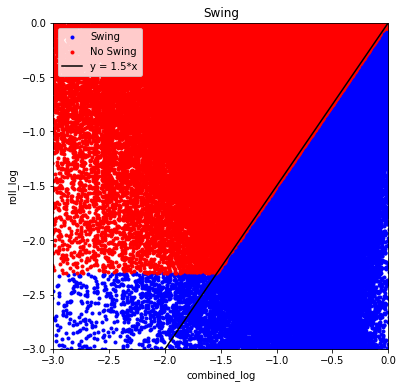

In [8]:
x_val = "combined_log"
y_val = "roll_log"
fig, ax = plt.subplots(1, figsize=(6, 6))
ax.scatter(
    dfc[dfc["passed"]][x_val],
    dfc[dfc["passed"]][y_val],
    color="blue",
    label="Swing",
    marker='.',
)

ax.scatter(
    dfc[~dfc["passed"]][x_val],
    dfc[~dfc["passed"]][y_val],
    color="red",
    label="No Swing",
    marker='.',
)


ax.set_xlabel(x_val)
ax.set_ylabel(y_val)
ax.set_title(f"Swing")
ax.set_ylim(-3, 0)
ax.set_xlim(-3, 0)

# if x_val == "threshold":
ax.plot(ax.get_xlim(), np.array(ax.get_xlim())*1.5, 'k', label="y = 1.5*x")

ax.legend(loc="upper left")
fig.savefig("../figures/swing_balls_log.png", facecolor="white")

In [9]:
print(dfc["combined"].argmin())
print(dfc.iloc[dfc["combined"].argmin(), :])
# print(dfc["offset"].iloc[dfc["combined"].argmin()])

233011
event_type             Ball
roll               0.030301
passed                False
batter_buoyancy    1.327099
batter_divinity    0.987449
                     ...   
roll_pow           0.097193
roll_log          -3.496578
combined          -0.446258
combined_pow            NaN
combined_log            NaN
Name: 304636, Length: 147, dtype: object


In [10]:
X = dfc[
    [
        "roll",
        # "roll_pow",
        "passed",
        "combined_pow",
    ]
].copy()
# X = X[X['roll_pow'] < 0.9]
# X = X[X['roll_pow'] > 0.2]
# X["roll"] = (X["roll"] - 0.05)**(1/1.4)
X = X[~X["combined_pow"].isna()]
X = X[X["roll"] < 0.95]
X = X[X["roll"] > 0.1]
# X = X.drop("roll", axis=1)

# pin_intercept = None
pin_intercept = 0
pins = [
    # (0.05333333, "combined")
]
# for val, var in pins:
#     X["roll_pow"] -= X[var] * val
#     X = X.drop(var, axis=1)

y = X["passed"]
X = X.drop(["passed"], axis=1)

In [11]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import svm, linear_model


sc = StandardScaler(with_mean=False)
X2 = sc.fit_transform(X)
if pin_intercept is not None:
    X2[:,0] -= pin_intercept / sc.scale_[0]

trainedsvm = svm.LinearSVC(dual=False, max_iter=500000, C=1000000000000, tol=1e-15,
                           fit_intercept=pin_intercept is None).fit(X2, y)
predictionsvm = trainedsvm.predict(X2)
print(confusion_matrix(y, predictionsvm))
# print(classification_report(y, predictionsvm))
print(trainedsvm.score(X2, y))

[[158073      0]
 [     0  54970]]
1.0


In [12]:
coef = np.true_divide(trainedsvm.coef_, sc.scale_)
coef_scaled = coef / coef[0, 0]
coef_list = coef_scaled.tolist()[0]

intercept = trainedsvm.intercept_# - np.dot(coef, sc.mean_)
intercept_scaled = -(intercept / coef[0, 0])[0] if pin_intercept is None else pin_intercept

dfc["threshold"] = intercept_scaled
print("intercept:", intercept_scaled)
for pair in pins + list(zip(-np.array(coef_list), X.columns)):
    if pair[1] not in ["roll", "roll_pow"]:
        print(pair)
        dfc["threshold"] += pair[0] * dfc[pair[1]]

dfc["threshold"] = dfc["combined_pow"].copy()
dfc.loc[dfc["threshold"] > 0.95, "threshold"] = 0.95
dfc.loc[dfc["threshold"] < 0.10, "threshold"] = 0.10

intercept: 0
(0.9999993290133234, 'combined_pow')


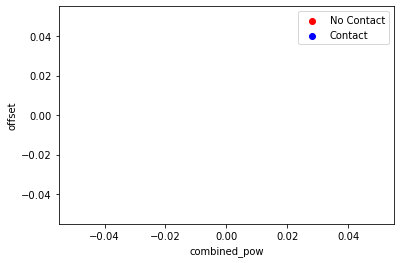

In [13]:
dfc["offset"] = dfc["roll"] - dfc["threshold"]
outliers = dfc[(dfc["passed"] & (dfc["offset"] >= 0)) | (~dfc["passed"] & (dfc["offset"] <= 0))]

fig, ax = plt.subplots(1)
x_val = "combined_pow"
y_val = "offset"
ax.scatter(
    outliers[~outliers["passed"]][x_val],
    outliers[~outliers["passed"]][y_val],
    color="red",
    label="No Contact",
)
ax.scatter(
    outliers[outliers["passed"]][x_val],
    outliers[outliers["passed"]][y_val],
    color="blue",
    label="Contact",
)
ax.set_xlabel(x_val)
ax.set_ylabel(y_val)
ax.legend()

In [14]:
pd.set_option("display.max_columns", None)
table = outliers[
    [
        "passed",
        "offset",
        # "event_type",
        # "weather",
        # "batter_laserlikeness",
        "roll",
        "roll_pow",
        "threshold",
        "ruth",
        "combined",
        # "combined_batting",
        # "combined_batting_0.5",
        # "combined_batting_1.25",
        # "combined_batting_0.25",
        "pitcher_multiplier",
        "batter_multiplier",
        "batter_name",
        "pitcher_name",
        "batter_mods",
        "pitcher_mods",
        "batting_team_mods",
        "pitching_team_mods",
        "season",
        "day",
        "game_id",
        "play_count",
        # "batter_vibes"
        # "fielder_roll",
    ]
]
print(len(table))
table.sort_values("offset", ascending=False)
print(dfc["combined"].min())
print(dfc["combined"].argmin())
print(dfc.loc[:, [
    "passed",
    "offset",
    "roll",
    "threshold",
    "ruth_scaled",
    "mox_scaled",
    "path_scaled",
    "ballpark_viscosity",
    "combined",
    "combined_pow",
    "pitcher_multiplier",
    "batter_multiplier",
    "batter_name",
    "pitcher_name",
    "batter_mods",
    "pitcher_mods",
    "batting_team_mods",
    "pitching_team_mods",
    "season",
    "day",
    "game_id",
    "play_count",
    "weather",
    "batter_vibes",
    "pitcher_vibes"
    ]].iloc[dfc["combined"].argmin()])

0
-0.4462581022357213
233011
passed                                               False
offset                                                 NaN
roll                                              0.030301
threshold                                              NaN
ruth_scaled                                       0.396496
mox_scaled                                        3.093893
path_scaled                                       0.000667
ballpark_viscosity                                0.445754
combined                                         -0.446258
combined_pow                                           NaN
pitcher_multiplier                                     1.0
batter_multiplier                                      1.5
batter_name                                  Jaxon Buckley
pitcher_name                                   Kit Adamses
batter_mods                                     FIRE_EATER
pitcher_mods                                           NaN
batting_team_mods          

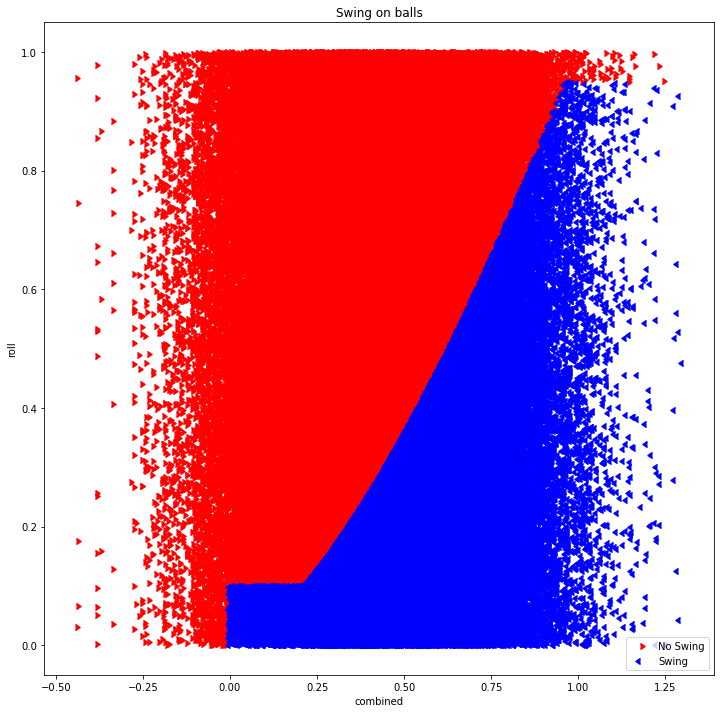

In [15]:
x_val = "combined"
y_val = "roll"
fig, ax = plt.subplots(1, figsize=(12, 12))

ax.scatter(
    dfc[~dfc["passed"]][x_val],
    dfc[~dfc["passed"]][y_val],
    color="red",
    label="No Swing",
    marker=CARETRIGHTBASE,
)
ax.scatter(
    dfc[dfc["passed"]][x_val],
    dfc[dfc["passed"]][y_val],
    color="blue",
    label="Swing",
    marker=CARETLEFTBASE,
)

ax.set_xlabel(x_val)
ax.set_ylabel(y_val)
ax.set_title(f"Swing on balls")

if x_val == "threshold":
    ax.plot(ax.get_xlim(), ax.get_xlim())

ax.legend(loc="lower right")
# ax.set_ylim(0, 0.3)

In [16]:
dfc[dfc["passed"]]["combined"].min()

7.001480645165702e-05

In [17]:
print(12 * 0.396496)
print(5 * 3.093893)
print(5 * 0.001)
print(4 * 0.445754)
print(-(-5 * 3.093893 + 5 * 0.001 + 4 * 0.445754)/12)
print(((12 * 1.5 - 5 * 3.093893 + 5 * 0.001 + 4 * 0.445754)/20)**1.5)

4.757952
15.469465
0.005
1.783016
1.14012075
0.10033722499338585
